In [170]:
import pandas as pd
import numpy as np
import os

from scipy.stats import pearsonr

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

## Read zones' parking data - Zone 1

In [171]:
zone1 = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')


In [172]:
zone1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 2020-07-13 10:00:00 to 2020-07-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   free    330 non-null    float64
dtypes: float64(1)
memory usage: 7.0 KB


In [173]:
zone1.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


## Read mobility subflows (resampled)

In [174]:
subflows_resampled= {}
for c in range(6,11):
    df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean.csv'.format(c)),
                   parse_dates=[0], index_col=0)
    subflows_resampled[c] = df

In [175]:
subflows_resampled[6].head()

,n_viajes_old,n_viajes
2020-07-01 00:00:00,5.219,5.219000
2020-07-01 01:00:00,5.219,5.219000
2020-07-01 02:00:00,NaN,6.855667
2020-07-01 03:00:00,NaN,8.492333
2020-07-01 04:00:00,10.129,10.129000


In [176]:
subflows_resampled[6].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-07-01 00:00:00 to 2020-07-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_viajes_old  570 non-null    float64
 1   n_viajes      744 non-null    float64
dtypes: float64(2)
memory usage: 17.4 KB


## Visual analysis

### Global plot for zone 1

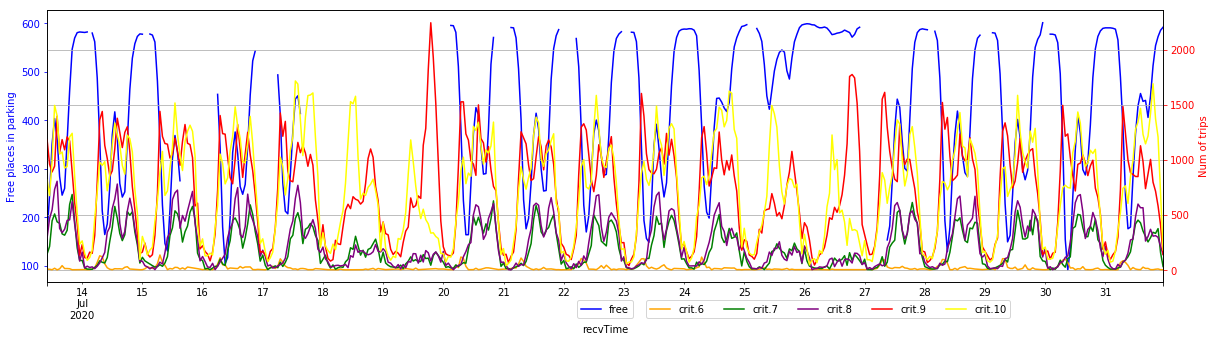

In [177]:
target_days = zone1.index
ax= zone1.plot(figsize=(20,5), label='Free places', color='blue')

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))

subflows_resampled[6].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.6', color='orange')
subflows_resampled[7].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.7', color='green')
subflows_resampled[8].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.8', color='purple')
subflows_resampled[9].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.9', color='red')
subflows_resampled[10].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.10', color='yellow')


ax.set_ylabel('Free places in parking')
ax2.set_ylabel('Num of trips');

ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')

ax.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red')

leg = ax.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=2)
leg = ax2.legend(loc='center', bbox_to_anchor=(0.7, -0.10), shadow=False, ncol=5)

plt.show()

### Side by side plot

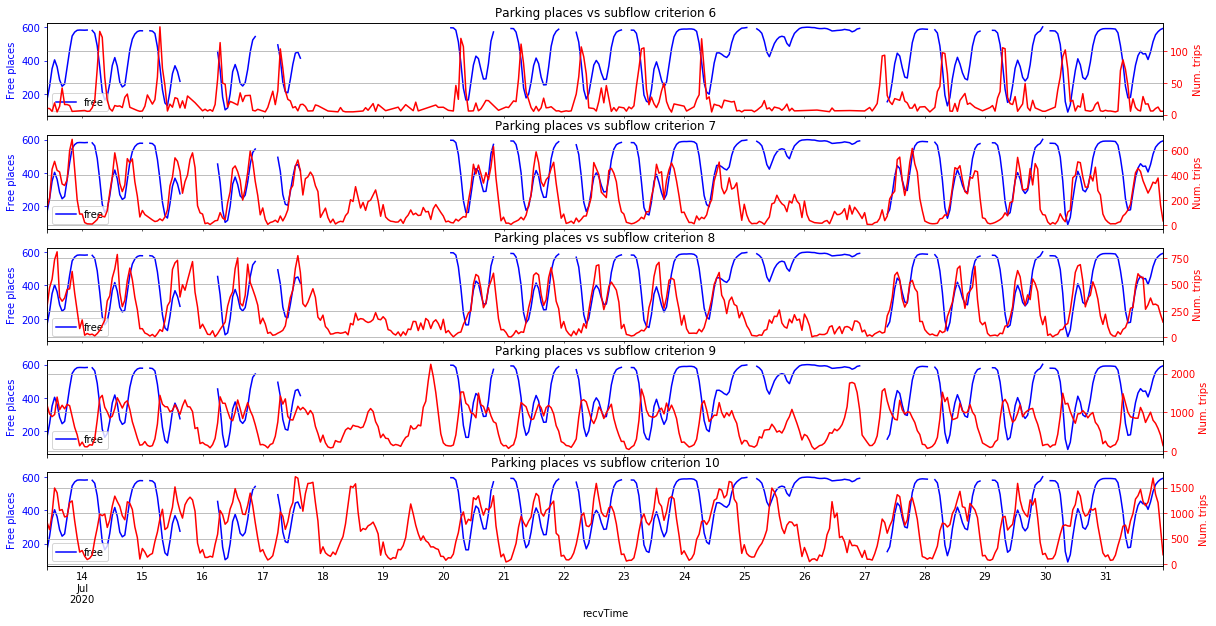

In [178]:
f, axes = plt.subplots(5, 1, figsize=(20,10), sharey='row', sharex='col')
axe = axes.ravel()
subflows= {}
i=0
for c in range(6,11):
    zone1.plot(ax= axe[i], color='blue', title='Parking places vs subflow criterion {}'.format(c))
    ax2 = axe[i].twinx()
    ax2.spines['right'].set_position(('axes', 1.0))

    subflows_resampled[c].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, color='red')
    
    axe[i].set_ylabel('Free places')
    ax2.set_ylabel('Num. trips')
    axe[i].yaxis.label.set_color('blue')
    ax2.yaxis.label.set_color('red')

    axe[i].tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')
    
    i +=1
    

### Correlation analysis

We just keep with the non-null values of the time series

In [179]:
zone1_no_nan = zone1.dropna()

In [180]:
zone1_no_nan.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


In [181]:
new_target_days = zone1_no_nan.index

In [182]:
for c in range(6,11):
    r, p= pearsonr(subflows_resampled[c].loc[new_target_days]['n_viajes'], zone1_no_nan['free'])
    print(f"Criterion {c}: Scipy computed Pearson r: {r} and p-value: {p}")

Criterion 6: Scipy computed Pearson r: -0.38428538341626195 and p-value: 4.687735056375462e-13
Criterion 7: Scipy computed Pearson r: -0.16493507390007991 and p-value: 0.002652014328491634
Criterion 8: Scipy computed Pearson r: -0.2579334572317833 and p-value: 2.0503025677927646e-06
Criterion 9: Scipy computed Pearson r: -0.6836434862581932 and p-value: 8.737142131495749e-47
Criterion 10: Scipy computed Pearson r: -0.44565142623562837 and p-value: 1.6609195628548873e-17
